# Interpret topic-model results

We ran ```topicmodel_gridsearch.Rmd``` five times, producing five different versions of ```topicmodel_deltas.csv.``` (All uploaded to github.)

The code below averages the five runs, and then pairs the averaged results with a data frame called ```interpret``` that stores the topic categorizes and sizes (the percentage of the corpus in each topic). These are used to produce a weighted average of delta across the corpus.

In [50]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_ind, linregress

### Load the results of the R scripts.

In [2]:
root = 'topicmodel_deltas'

deltas = dict()

for i in range(1, 6):
    
    suffix = str(i) + '.csv'
    deltas[i] = pd.read_csv(root + suffix)
    
print(len(deltas), ' files loaded.')

5  files loaded.


There is some continuity but also sigificant divergence between different runs.

In [3]:
deltas[4].head()

,depvar,cmse,pmse,totalr2,delta,adjdelta,bywidth,fpwidth,bydf,fpdf,pmse_oos,cmse_oos,delta_oos,r2_oos,agemse
0,t0,10.625,208.397,0.047679,0.048511,0.196610,by_20,fp_4,5,24,0.077930,0.000150,0.001923,0.021714,0.191
1,t1,24.556,19.209,0.018856,0.561088,0.754183,by_20,fp_8,5,12,0.021526,0.085478,0.798832,0.000835,2.668
2,t2,34.288,17.816,0.010280,0.658068,0.590738,by_16,fp_16,8,6,0.031632,0.042898,0.575584,-0.008059,5.460
3,t3,45.291,141.936,0.135140,0.241904,0.433693,by_20,fp_8,5,12,0.158778,0.031397,0.165094,0.124308,11.181
4,t4,57.918,14.794,0.027720,0.796540,0.681065,by_12,fp_16,11,6,0.009295,0.045823,0.831364,0.005274,6.106


In [4]:
# How much stability is there between runs?

# Note: I'm using arctanh and tanh to average correlation coefficients
# because r is not normally distributed; it's bounded at 1 and -1, so
# a Fisher's z-transform is needed.

deltalist = []
deltaooslist = []

for i in range(1, 6):
    for j in range(i + 1, 6):
        deltalist.append(spearmanr(deltas[i].delta, deltas[j].delta)[0])
        deltaooslist.append(spearmanr(deltas[i].delta_oos, deltas[j].delta_oos)[0])

def average_rs(rlist):
    r_z = [np.arctanh(x) for x in rlist]
    return np.tanh(np.mean(r_z))
        
print('Avg spearman in-sample: ', average_rs(deltalist))
print('Avg spearman oos: ', average_rs(deltaooslist))


Avg spearman in-sample:  0.6812679121994941
Avg spearman oos:  0.4846775474410862


### Construct a data frame that has average values

In [5]:
smoothed = dict()

cols = ['delta', 'adjdelta', 'delta_oos', 'cmse', 'pmse', 'cmse_oos', 'pmse_oos', 
        'totalr2', 'r2_oos', 'bydf', 'fpdf', 'agemse']

for c in cols:
    if c not in smoothed:
        smoothed[c] = []
    for rownum in range(200):
        values = []
        for i in range(1, 6):
            if c in deltas[i].columns:      # the only exception is 'agemse' which got added late
                                            # and won't be in all five runs
                values.append(deltas[i].loc[rownum, c])
        smoothed[c].append(np.mean(values))

        
avgdf = pd.DataFrame(smoothed)

In [6]:
avgdf.head()

,delta,adjdelta,delta_oos,cmse,pmse,cmse_oos,pmse_oos,totalr2,r2_oos,bydf,fpdf,agemse
0,0.052664,0.185230,0.078345,11.6860,209.5212,0.020000,0.102817,0.047869,0.024379,6.2,24.0,0.53325
1,0.578712,0.596288,0.689357,25.0768,16.0822,0.061597,0.017510,0.017090,0.003942,4.8,6.0,2.13175
2,0.642251,0.671377,0.433169,16.1334,9.5950,0.012027,0.011970,0.006939,-0.004519,4.8,5.4,2.73375
3,0.238089,0.454468,0.140974,46.8034,151.2078,0.029488,0.198506,0.136532,0.122522,5.6,16.0,9.89675
4,0.783425,0.661006,0.809441,61.5444,17.3744,0.078168,0.020837,0.028121,0.011077,8.6,4.8,4.91075


In [7]:
# How close are different runs to the average?

for i in range(1, 6):
    print('In sample: ', spearmanr(deltas[i].delta, avgdf.delta)[0])
    print('Out of sample: ', spearmanr(deltas[i].delta_oos, avgdf.delta_oos)[0])

In sample:  0.8074056851421287
Out of sample:  0.6886982505044134
In sample:  0.8504282607065178
Out of sample:  0.720337209699844
In sample:  0.8517287932198306
Out of sample:  0.7669871746793672
In sample:  0.8932303307582691
Out of sample:  0.778130953273832
In sample:  0.8874971874296859
Out of sample:  0.8414745368634217


### Load the coding of the 200 topics

In [8]:
interpret = pd.read_csv('../interrater/k200standardcoding.tsv', sep = '\t')
interpret.drop(columns = ['next5books, biggestauth, datequartiles', 'comments'], inplace = True)
interpret.head()

,topicstats,keywords,top7books,label,category
0,TOPIC 0 pct corpus = 0.267% doc entropy = 9.80...,war german french germans france germany ameri...,"0.136 | Gibbs, Philip | Through the storm | 19...","war, mostly WWII",event
1,TOPIC 1 pct corpus = 0.288% doc entropy = 9.74...,professor man quite something thing old little...,"0.177 | Stewart, J. I. M. (John Innes | Hare ...","e20c scientists, labs, and professors, mostly ...",genre
2,TOPIC 2 pct corpus = 0.479% doc entropy = 10.4...,door put box paper hand took room went made po...,"0.489 | Sellers, Tom | Unknown Title | 1927 0....","objects in relation to doors, pockets, rooms, ...",physical description
3,TOPIC 3 pct corpus = 0.388% doc entropy = 9.34...,american people president our security re new ...,"0.297 | Digo, Benjamin | Creator of Nikho | 19...",late 20c US political thrillers,genre
4,TOPIC 4 pct corpus = 0.666% doc entropy = 10.3...,man old people men because knew good always bi...,"0.157 | Hanley, Gerald | Drinkers of darkness ...",diffuse,uncategorized dimension of style


For our present purposes, we don't need all this information, and we could use shorter category labels for visualization.

In [9]:
# FUNCTIONS THAT SIMPLIFY AND CLEAN THE CODING FRAME

def getpct(astring):
    firstpart = astring.split('%')[0]
    number = float(firstpart.split('= ')[1])
    return number

def shorten(astring):
    shortversion = astring[0:6]
    if shortversion == 'human ':
        shortversion = 'institu' # for human institution, practice, or relationship
    return shortversion

interpret['pct'] = interpret.topicstats.map(getpct)
interpret['category'] = interpret.category.map(shorten)
interpret.drop(columns = ['keywords', 'top7books', 'topicstats'], inplace = True)
interpret.head()

,label,category,pct
0,"war, mostly WWII",event,0.267
1,"e20c scientists, labs, and professors, mostly ...",genre,0.288
2,"objects in relation to doors, pockets, rooms, ...",physic,0.479
3,late 20c US political thrillers,genre,0.388
4,diffuse,uncate,0.666


### Concatenate the topic labels with all five frames of numeric results.

In [10]:
topics = dict()
for i in range(1, 6):
    topics[i] = pd.concat([deltas[i], interpret], axis = 1)

### And also with the average of all five.

In [11]:
avgdf = pd.concat([avgdf, interpret], axis = 1)

In [12]:
def weighted_avg(aframe):
    avg = sum(aframe.pct * aframe.cmse) / (sum(aframe.pct * aframe.cmse) + sum(aframe.pct * aframe.pmse))
    return avg

def weighted_avg_oos(aframe):
    cmseoos = [0 if i < 0 else i for i in aframe.cmse_oos]
    pmseoos = [0 if i < 0 else i for i in aframe.pmse_oos]  
    avg = sum(aframe.pct * cmseoos) / (sum(aframe.pct * cmseoos) + sum(aframe.pct * pmseoos))
    return avg

### Calculate average delta as per our pre-registered plan.

The columns that matter most are the "weighted" ones; we've already decided to care more about variables where the model is strong than about ones where r2 is low and no chronological variables are very predictive--also more about large topics than small ones.

In [13]:
print('raw in-sample\traw oos\t\tweighted in-sample\tweighted oos')
for i in range(1, 6):
    print(round(np.mean(topics[i].delta), 4), '\t\t', round(np.mean(topics[i].delta_oos), 4), '\t\t',
          round(weighted_avg(topics[i]), 4), '\t\t', round(weighted_avg_oos(topics[i]), 4))

raw in-sample	raw oos		weighted in-sample	weighted oos
0.5342 		 0.5011 		 0.5149 		 0.501
0.5432 		 0.4899 		 0.5331 		 0.5109
0.5621 		 0.4914 		 0.5372 		 0.4491
0.5553 		 0.5112 		 0.5653 		 0.5202
0.5551 		 0.493 		 0.5641 		 0.4744


In [14]:
print("Overall, weighted in-sample is", round(weighted_avg(avgdf), 4))
print("And out-of-sample: ", round(weighted_avg_oos(avgdf), 4))

Overall, weighted in-sample is 0.544
And out-of-sample:  0.4914


Actually, technically we proposed to exclude 'accidents of transcription' and 'author-dominated' categories from the average. This makes only a small difference.

In [15]:
legit = avgdf.loc[(avgdf.category != 'accide') & (avgdf.category != 'author'), :]
print("Overall, weighted in-sample is", round(weighted_avg(legit), 4))
print("And out-of-sample: ", round(weighted_avg_oos(legit), 4))

Overall, weighted in-sample is 0.5466
And out-of-sample:  0.4929


### Differences between topic categories

Our article focuses on the way r2 is partitioned by ANOVA (in-sample). In theory there are advantages to calculating on out-of-sample data, but I suspect in practice it's noisier, as seen by the low Spearman correlations in cells above.

Here are category means (not weighted by topic size or r2):

In [16]:
cats = avgdf.category.unique()
deltadict = dict()
for c in cats:
    deltadict[c] = avgdf.loc[avgdf.category == c, 'delta'].tolist()
    print(c, np.mean(deltadict[c]))

event 0.3459638814227623
genre 0.5026526511882805
physic 0.6146181817452785
uncate 0.5398023378033946
techno 0.5748519565449998
institu 0.5550869014006015
dialec 0.5235631123147099
nation 0.6314228701069845
author 0.5601742301152037
accide 0.5010640282588195


And a visualization.

In [17]:
def widen (astring):
    mapper = {'event': 'event', 'genre': 'genre', 'dialec': 'dialect or language', 'accide': 'accident of transcription', 'author': 'author-dominated topic',  
              'techno': 'technological change', 'uncate': 'uncategorized', 'institu': 'institution or practice', 'nation': 'nationality or region', 
              'physic': 'physical description'}
    return mapper[astring]

avgdf['longcategory'] = avgdf.category.map(widen)

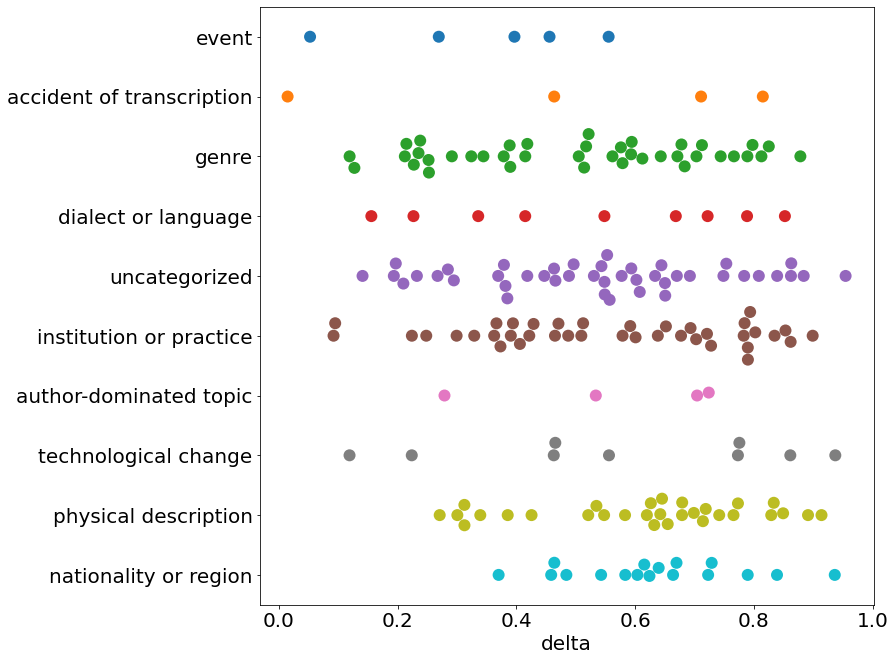

In [19]:
cm = 1/2.54
plt.figure(figsize = (11, 11))
res = sns.swarmplot(data = avgdf, x = 'delta', y = 'longcategory', order = ['event', 'accident of transcription', 'genre',
                                                                            'dialect or language', 'uncategorized',   
                                                                   'institution or practice',
                                                                     'author-dominated topic', 'technological change',
                                                                    'physical description', 'nationality or region'], orient = 'h', size = 12)
plt.rcParams.update({'font.size': 20})
plt.ylabel('')
plt.gcf().set_facecolor('white')
# plt.savefig('/Users/tunder/Dropbox/python/cohort/figures/swarmdeltas.png', bbox_inches = 'tight', dpi = 300)
plt.show()

The most dramatic and stable pattern is that 'event' topics have much lower delta, and are more dominated by period factors. Here they are; as you can see, they're mostly wars.

In [20]:
avgdf.loc[avgdf.category == 'event', : ]

,delta,adjdelta,delta_oos,cmse,pmse,cmse_oos,pmse_oos,totalr2,r2_oos,bydf,fpdf,agemse,label,category,pct,longcategory
0,0.052664,0.185230,0.078345,11.6860,209.5212,0.020000,0.102817,0.047869,0.024379,6.2,24.0,0.53325,"war, mostly WWII",event,0.267,event
63,0.269352,0.395927,0.023510,10.7786,29.9736,0.000621,0.023230,0.012020,-0.003758,4.8,9.6,0.30050,revolutionary and communist movements,event,0.348,event
86,0.555281,0.565166,0.478879,42.1664,34.0802,0.017909,0.022856,0.018071,0.002273,6.2,7.2,0.61975,"warfare, probably centered on WWI",event,0.212,event
110,0.396742,0.412263,0.437117,19.9406,30.8042,0.035048,0.060875,0.018361,0.009139,4.2,5.0,14.68125,war,event,0.290,event
145,0.455780,0.446869,0.398534,38.5564,24.9040,0.041446,0.021034,0.020356,0.003584,9.0,7.8,1.32425,"warfare, probably centered on WWI",event,0.349,event


This pattern holds just as strongly if we measure delta out of sample.

In [21]:
deltadict = dict()
for c in cats:
    deltadict[c] = avgdf.loc[avgdf.category == c, 'delta_oos'].tolist()
    print(c, np.mean(deltadict[c]))

event 0.28327698908099014
genre 0.455283098077434
physic 0.5622033403804738
uncate 0.5099162772023974
techno 0.5246996750387279
institu 0.48537258233713987
dialec 0.47393976436511676
nation 0.551549844214966
author 0.4782241188448603
accide 0.4602915081588345


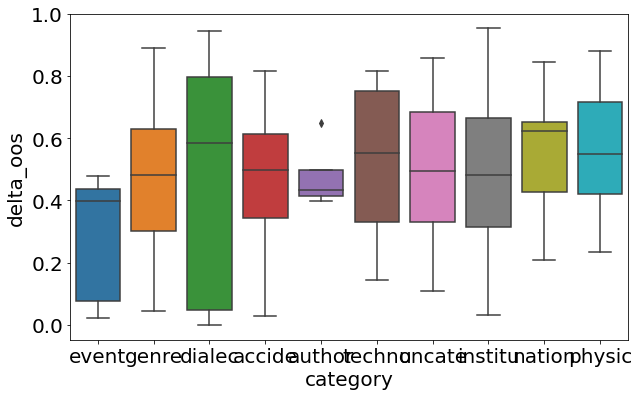

In [22]:
plt.figure(figsize = (10, 6))
sns.boxplot(data = avgdf, x = 'category', y = 'delta_oos', order = ['event', 'genre','dialec', 'accide', 'author',  'techno', 'uncate',  
                                                                  'institu', 'nation', 'physic'])
plt.rcParams.update({'font.size': 12})
plt.show()

### Testing our pre-registered hypothesis about categories

We specified that we didn't expect *p* < .05 kind of significance here, because n is very low (n for the three categories is 5, 4, and 9)!

Instead we were going to look at effect size. For instance, Cohen's *d*. And any way you measure this (in or out of sample), there is in fact a non-trivial effect.

But this is mostly the ```event``` (and to some extent ```accident```) topics pulling down the ```technology``` category. If we just considered the technology topics by themselves, they wouldn't seem notably divergent from the rest of the model.

So our hypothesis is confirmed, but with some internal variation that shows we're not seeing exactly what we might have expected.

In [23]:
target_cat_deltas = avgdf.loc[(avgdf.category == 'event') | (avgdf.category == 'accide') | (avgdf.category == 'techno'), 'delta']
np.mean(target_cat_deltas)

0.4948746182807826

In [24]:
other_deltas = avgdf.loc[(avgdf.category != 'event') & (avgdf.category != 'accide') & (avgdf.category != 'techno'), 'delta']
np.mean(other_deltas)

0.5554477741932468

In [25]:
## Calculate Cohen's d.

(np.mean(other_deltas) - np.mean(target_cat_deltas)) / np.std(avgdf.delta)

0.2819610452134753

### Where is r2 strong?

This is a bit of a surprise. "Genre" and "physical description" are the categories where chronological variables have most explanatory power.

I might have expected ```technology``` and ```event``` to have higher r2s.

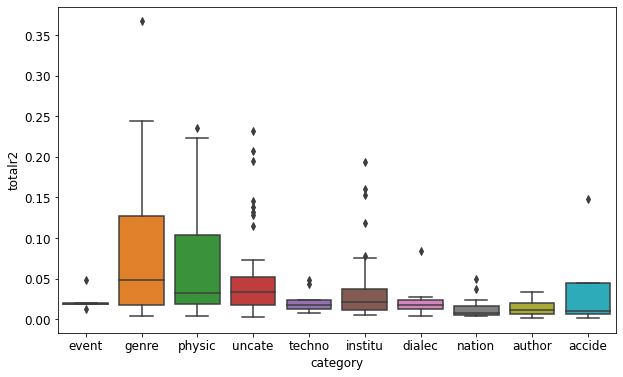

In [29]:
plt.figure(figsize = (10, 6))
sns.boxplot(data = avgdf, x = 'category', y = 'totalr2')
plt.show()

### Calculate average r2 weighted by topic size

In [30]:
weightedavgr2 = np.average(avgdf.totalr2, weights = avgdf.pct)
print('r2: ', weightedavgr2)

r2:  0.06013832060140532


In [31]:
naiver2 = np.mean(avgdf.totalr2)
naiver2

0.04824305555910859

In [32]:
pearsonr(avgdf.totalr2, avgdf.delta)

(-0.13701026594934354, 0.05303869605258556)

In [33]:
pearsonr(avgdf.totalr2, avgdf.pct)

(0.3152599825163253, 5.441744444581996e-06)

So, there's a significant and moderately strong pattern that r2 is larger when a topic contains more words. Not very surprising.

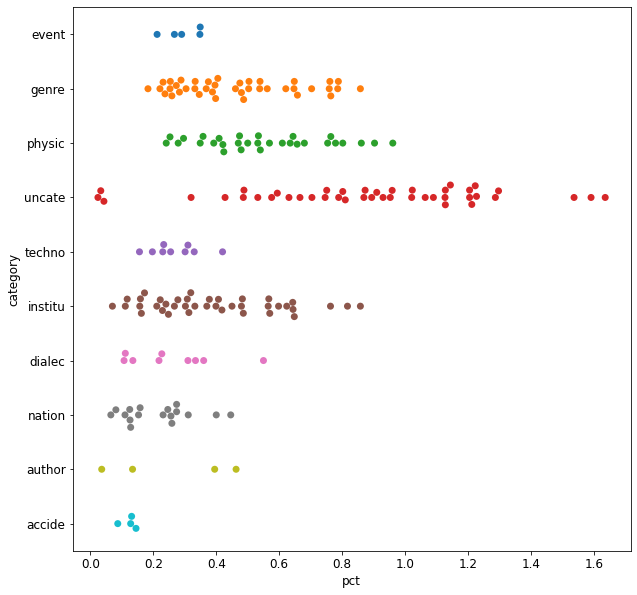

In [35]:
plt.figure(figsize = (10, 10))
sns.swarmplot(data = avgdf, y = 'category', x = 'pct', orient = 'h', size = 7)
plt.show()

Categories are quite strongly grouped, but this is not altogether surprising since r2 correlates with topic size and topic size is one of the things we looked at in categorizing.

### Examine particular topics to understand patterns better

Let's look at the trajectories of topics over time to understand why they are associated with period or cohort.

In [36]:
bookdata = pd.read_csv('../topicdata/bookleveltopicdata.tsv', sep = '\t', low_memory = False) 

In [37]:
data = bookdata.loc[bookdata.us_national & (bookdata.firstpub > 1889) & (bookdata.firstpub < 1990), : ]
data.shape

(5572, 208)

In [38]:
def extract_trajectories(depvar, data):
    avgbyfirstpub = []
    avgbybirthyear = []
    firstpubtimeline = []
    birthyeartimeline = []
    for fp, df in data.groupby('firstpub'):
        if fp > 1889 and fp < 1990:
            firstpubtimeline.append(fp)
            avgbyfirstpub.append(np.mean(df[depvar]))
            
    for by, df in data.groupby('birthyear'):
        if by > 1850 and by < 1960:
            birthyeartimeline.append(by)
            avgbybirthyear.append(np.mean(df[depvar]))
    
    return firstpubtimeline, avgbyfirstpub, birthyeartimeline, avgbybirthyear

In [39]:
fpxaxis, avgbyfirstpub, byxaxis, avgbybirthyear = extract_trajectories('t0', data)

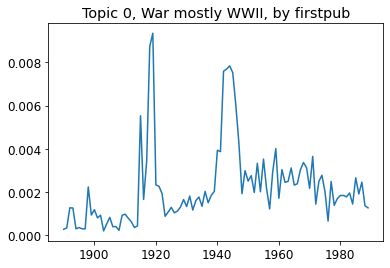

In [40]:
sns.lineplot(x = fpxaxis, y = avgbyfirstpub)
plt.title('Topic 0, War mostly WWII, by firstpub')
plt.show()

You can see why models of that trajectory invariably choose a 4-year granularity. It's very tightly responsive to events.

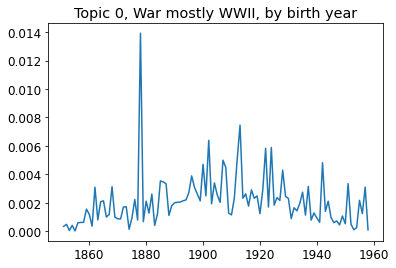

In [41]:
sns.lineplot(x = byxaxis, y = avgbybirthyear)
plt.title('Topic 0, War mostly WWII, by birth year')
plt.show()

Although there is one crazy spike there, models of birthyear choose a 16-year granularity on average, because it's a smoother pattern on the whole.

In [42]:
fpxaxis, avgbyfirstpub, byxaxis, avgbybirthyear = extract_trajectories('t141', data)

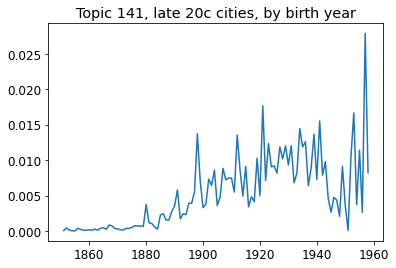

In [43]:
sns.lineplot(x = byxaxis, y = avgbybirthyear)
plt.title('Topic 141, late 20c cities, by birth year')
plt.show()

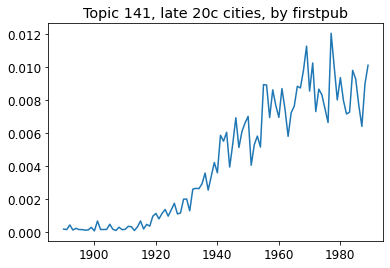

In [44]:
sns.lineplot(x = fpxaxis, y = avgbyfirstpub)
plt.title('Topic 141, late 20c cities, by firstpub')
plt.show()

In [45]:
x = []
y = []
variable = []
topicnumber = []

for tn in ['t0', 't141']:
    fpxaxis, avgbyfirstpub, byxaxis, avgbybirthyear = extract_trajectories(tn, data)
    if tn == 't0':
        topicname = "War"
    else:
        topicname = "Urban life"
        
    x.extend(fpxaxis)
    y.extend(avgbyfirstpub)
    variable.extend(['pub. year'] * len(fpxaxis))
    topicnumber.extend([topicname] * len(fpxaxis))
    
    x.extend(byxaxis)
    y.extend(avgbybirthyear)
    variable.extend(["birth year"] * len(byxaxis))
    topicnumber.extend([topicname] * len(byxaxis))

facetdf = pd.DataFrame({'year': x, 'prominence': y, 'x': variable, 'topic': topicnumber})

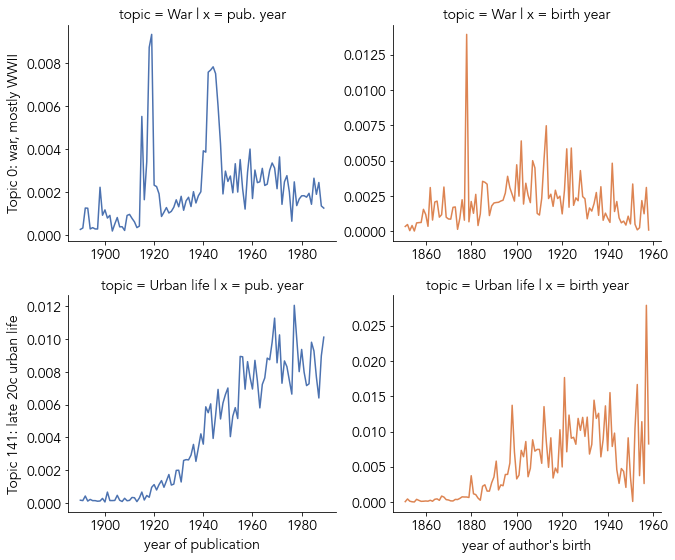

In [46]:
plt.rcParams.update({'font.sans-serif':'Avenir'})
plt.rcParams.update({'font.size': 14})
g = sns.FacetGrid(facetdf, row = 'topic', col = 'x', hue = 'x', height = 4, aspect = 1.2, 
                  sharex = False, sharey = False, palette = 'deep')
g.map(sns.lineplot, 'year', 'prominence')

g.axes[1,0].set_xlabel('year of publication')
g.axes[1,1].set_xlabel("year of author's birth")
g.axes[1,0].set_ylabel("Topic 141: late 20c urban life")
g.axes[0,0].set_ylabel('Topic 0: war, mostly WWII')
plt.gcf().set_facecolor('white')
# plt.savefig('/Users/tunder/Dropbox/python/cohort/figures/lineplotgrid.png', bbox_inches = 'tight', dpi = 300)

### A slope hypothesis producing null results

Patterns like the one below give us some reason to think that period-driven changes cause steep upslopes, whereas cohorts become more determinative when topics are in decline. (Writers "hold onto the practices they learned in youth.")

This seems to be true of crime fiction.

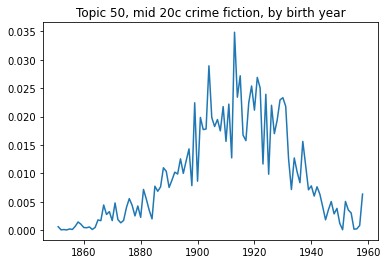

In [48]:
sns.lineplot(x = byxaxis, y = avgbybirthyear)
plt.title('Topic 50, mid 20c crime fiction, by birth year')
plt.show()

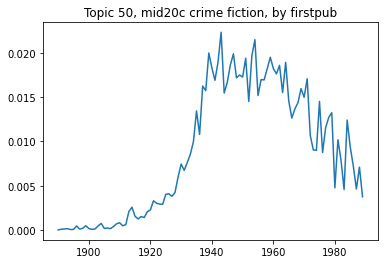

In [49]:
sns.lineplot(x = fpxaxis, y = avgbyfirstpub)
plt.title('Topic 50, mid20c crime fiction, by firstpub')
plt.show()

It's also supported by a pattern we find in the "technology" category. Generally speaking, emergent technologies, with a positive slope, are more period-driven than residual technologies, with a net negative slope across the century.

In [53]:
techno = avgdf.loc[avgdf.category == 'techno', : ].copy()
techno.sort_values(by = 'delta', inplace = True)

slopes = []

for idx, row in techno.iterrows():
    fpxaxis, avgbyfirstpub, byxaxis, avgbybirthyear = extract_trajectories('t' + str(idx), data)
    slope_0, intercept, r_value, p_value, std_err = linregress(fpxaxis, avgbyfirstpub)
    slopes.append(slope_0)

techno = techno.assign(slope = slopes)

techno.loc[ : , ['delta', 'slope', 'totalr2', 'bydf', 'fpdf', 'label']]

,delta,slope,totalr2,bydf,fpdf,label
164,0.119125,0.000043,0.042852,5.0,8.8,automobiles
22,0.223877,-0.000058,0.048069,5.4,5.8,e20c rail travel
122,0.462933,0.000047,0.023809,7.2,8.2,aeronautics
36,0.465517,0.000037,0.017820,6.4,5.4,late 20c hospitals
11,0.555884,-0.000025,0.012866,9.2,5.6,e20c industrial work
8,0.772940,-0.000004,0.012472,9.8,7.6,e20c medicine
134,0.775382,-0.000031,0.007277,4.8,5.2,boats and nautical matters
104,0.861139,-0.000012,0.010130,5.0,4.8,sea travel (and perhaps also colonialism?)
23,0.936870,-0.000031,0.018271,7.2,3.2,horse-drawn modes of transportation


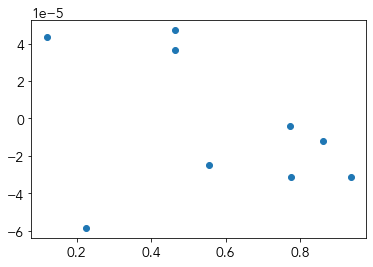

In [54]:
plt.scatter(techno.delta, techno.slope)

However we don't find a lot of evidence that this is true across all 200 topics.

In [55]:
slopes = []

for topnum in range(200):
    fpxaxis, avgbyfirstpub, byxaxis, avgbybirthyear = extract_trajectories('t' + str(topnum), data)
    slope_0, intercept, r_value, p_value, std_err = linregress(fpxaxis, avgbyfirstpub)
    # r2, p = spearmanr(byxaxis, avgbybirthyear)
    slopes.append(slope_0)

slopes = np.array(slopes)

In [56]:
pearsonr(slopes, avgdf.delta)

(-0.068023931869791, 0.33852541193795055)

### Comparison to the SEM experiment

How do the results of structural equation modeling compare to the deltas we inferred from our regression experiment?

First we load the SEM results.

In [64]:
sem = pd.read_csv('../sem-topics/sem_topic_preferred.csv')
sem

,topic,mod_spec,BIC,chisq,npar,rmsea,converged,nobs,type,BIC_diff,verdict
0,t0,SDM2,56969.193690,1.958359,4,0.000000,True,6927,SDM,-7.037195,SDM
1,t1,SDM2,48125.223978,8.597923,4,0.021823,True,6927,SDM,-1.259729,Inconclusive
2,t2,AUM4,55315.111779,0.168859,5,0.000000,True,6927,AUM,-55.808567,AUM
3,t3,AUM4,55520.822670,29.295657,5,0.063913,True,6927,AUM,-165.653195,AUM
4,t4,AUM4,54385.747324,0.864300,5,0.000000,True,6927,AUM,-4.858876,AUM
...,...,...,...,...,...,...,...,...,...,...,...
195,t195,AUM4,54113.247327,262.560467,5,0.194318,True,6927,AUM,-106.085575,AUM
196,t196,AUM4,56859.515032,0.917575,5,0.000000,True,6927,AUM,-72.102139,AUM
197,t197,AUM4,59206.695610,248.831882,5,0.189150,True,6927,AUM,-85.240279,AUM
198,t198,AUM4,54100.603634,13.319917,5,0.042173,True,6927,AUM,-286.891595,AUM


Then we separate two categories of topics: those where the active updating model was preferred, and those where the settled disposition model was preferred.

In [65]:
aumdeltas = avgdf.loc[sem.verdict == 'AUM', 'delta']

In [66]:
sdmdeltas = avgdf.loc[sem.verdict == 'SDM', 'delta']

A naive approach would be to directly calculate the difference between these deltas by taking the means and using a t-test to evaluate the difference of means.

In [69]:
print('AUM: ', round(np.mean(aumdeltas), 4))
print('SDM: ', round(np.mean(sdmdeltas), 4))

AUM:  0.5283
SDM:  0.5956


In [70]:
ttest_ind(aumdeltas, sdmdeltas, equal_var = False) # Welch's t-test

Ttest_indResult(statistic=-2.063384036127074, pvalue=0.041240118896226474)

The difference would be significant, if we took that naive approach.

#### A better approach

However, recall that in reality we weight deltas both by $r^2$ and by the size of the topic when calculating overall delta. It's reasonable to apply the same weights to calculate the means of the two groups here, and apply them also to the t-test.

In [71]:
avgdf = avgdf.assign(weights = avgdf.pct * avgdf.totalr2)
avgdf = avgdf.assign(weights = avgdf.weights * (200 / sum(avgdf.weights)))

In [72]:
aumpct = avgdf.loc[sem.verdict == 'AUM', 'pct']
sdmpct = avgdf.loc[sem.verdict == 'SDM', 'pct']

In [73]:
aumr2 = avgdf.loc[sem.verdict == 'AUM', 'totalr2']
sdmr2 = avgdf.loc[sem.verdict == 'SDM', 'totalr2']
aumweights = aumpct * aumr2
sdmweights = sdmpct * sdmr2

In [74]:
allweights = np.concatenate([aumweights, sdmweights])
allweights = allweights * (len(allweights) / sum(allweights))
print(sum(allweights))

185.0000000000002


That's a sanity check; the numbers should add up to the length of the vectors.

In [75]:
aumweights = allweights[0 : len(aumweights)]
sdmweights = allweights[len(aumweights) : ]

In [76]:
from statsmodels.stats.weightstats import ttest_ind     # a more flexible implementation

In [77]:
ttest_ind(x1 = aumdeltas, x2 = sdmdeltas, weights = (aumweights, sdmweights), usevar = 'unequal')  # returns t statistic, pval, dfs

(-4.010727349462678, 0.0001524849609534686, 68.29695788078511)

In [78]:
np.average(aumdeltas, weights = aumweights)

0.49556172553283845

In [79]:
np.average(sdmdeltas, weights = sdmweights)

0.6448849511590758

Those are the means and statistics we report in the article.

In [80]:
sum((sem.verdict == 'AUM') & (avgdf.delta > 0.5))     # I quote this figure at one point

69

#### visualizing the difference of means described above

In [82]:
avgdf['semtype'] = sem.verdict.values

<AxesSubplot:xlabel='semtype', ylabel='delta'>

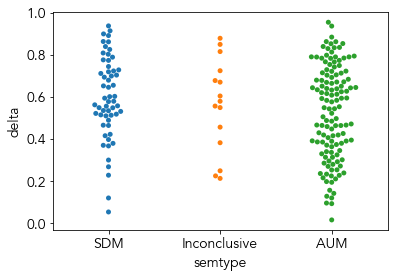

In [84]:
sns.swarmplot(data = avgdf, x = 'semtype', y = 'delta')